## 第一步，导入库

In [24]:
#导入包
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

## 数据预处理

我们的数据集将由标准化股票价格的时间戳组成，并且具有一个形如(banch_size,sequence_length,observation_length)的shape。

In [25]:
#导入数据
df=pd.read_excel('../data/equipment_loss_rate.xlsx',sheet_name='warship_generate')
print(df.head())
print(df.shape)
print(type(df['consume'].values[0]))#看看数据类型是不是float

      time    consume
0  2010/01  246.67281
1  2010/02  253.88689
2  2010/03  248.72287
3  2010/04  262.38641
4  2010/05  243.05669
(144, 2)
<class 'numpy.float64'>


变量解释：

df:保存表格数据的DataFrame

consume:未标准化的series

consume_arr:未标准化的 n*1 arr

consume_scale:标准化的 n*1 arr



In [26]:
#数据预处理

consume=df['consume']

scaler=StandardScaler()
consume_arr=np.array(consume).reshape(-1,1)
consume_scale=scaler.fit_transform(consume_arr) #标准化


创建一个函数来按照时间戳转换我们的股价历史记录。为此，使用最大长度等于我们正在使用的时间戳大小的双端队列，我们将每个数据点添加到双端队列，然后将其副本附加到主时间戳列表：

In [27]:
windows_size=12

def create_timestamps_ds(series,timestep_size=windows_size):
    time_stamps=[]
    labels=[]
    aux_deque=deque(maxlen=timestep_size)

    #starting the timestep deque
    for i in range(timestep_size):
        aux_deque.append(0)

    #feed the timestamps list
    for i in range(len(series)-1):
        aux_deque.append(series[i])
        time_stamps.append(list(aux_deque))

    #feed the labels list
    for i in range(len(series)-1):
        labels.append(series[i+1])

    assert len(time_stamps)==len(labels),'something went wrong'

    #torch-tensoring it
    features=torch.tensor(time_stamps[timestep_size:]).float()
    labels=torch.tensor(labels[timestep_size:]).float()

    return features,labels


我们的网络接受variantal_estimator装饰器，该装饰器可简化对贝叶斯神经网络损失的采样。我们的网络具有一个贝叶斯LSTM层，参数设置为in_features=1以及out_features=10，后跟一个nn.Linear(10,1),该层输出股票的标准化价格。

In [28]:
#神经网络类
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.lstm_1=BayesianLSTM(1,100)
        self.linear=nn.Linear(100,1)

    def forward(self,x):
        x_,_=self.lstm_1(x)

        #gathering only the latent end-of-sequence for the linear layer
        x_=x_[:,-1,:]
        x_=self.linear(x_)
        return x_

如您所见，该网络可以正常工作，唯一的不同点是BayesianLSTM层和variantal_estimator装饰器，但其行为与一般的Torch对象相同。

完成后，我们可以创建我们的神经网络对象，分割数据集并进入训练循环：

## 创建对象

我们现在可以创建损失函数、神经网络、优化器和dataloader。请注意，我们不是随机分割数据集，因为我们将使用最后一批时间戳来计算模型。由于我们的数据集很小，我们不会对训练集创建dataloader。

In [29]:
#将模型放到cuda上
print(torch.cuda.is_available())
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Xs,ys=create_timestamps_ds(consume_scale)
X_train,X_test,y_train,y_test=train_test_split(Xs,ys,test_size=.15,random_state=42,shuffle=False)
X_train,X_test,y_train,y_test=torch.tensor(X_train).to(device),\
                              torch.tensor(X_test).to(device),\
                              torch.tensor(y_train).to(device),\
                              torch.tensor(y_test).to(device)

ds=torch.utils.data.TensorDataset(X_train,y_train)
dataloader_train=torch.utils.data.DataLoader(ds,batch_size=72,shuffle=True)

net=NN().to(device)

#我们将使用MSE损失函数和学习率维0.001的Adam优化器
criterion=nn.MSELoss()
optimizer=optim.Adam(net.parameters(),lr=0.001)

True


<ipython-input-29-95e61b3afc7c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train,X_test,y_train,y_test=torch.tensor(X_train).to(device),\
<ipython-input-29-95e61b3afc7c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_test).to(device),\
<ipython-input-29-95e61b3afc7c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_train).to(device),\
<ipython-input-29-95e61b3afc7c>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach

## 训练循环

对于训练循环，我们将使用添加了variational_estimator的sample_wlbo方法。他对X个样本的损失进行平均，并帮助我们轻松地用蒙特卡洛估计来计算损失。

为了使网络正常工作，网络forward方法的输出必须与传入损失函数对象的标签形状一致。

In [30]:
iteration=0
for epoch in range(6000):
    for i,(datapoints,labels) in enumerate(dataloader_train):
        optimizer.zero_grad()

        loss=net.sample_elbo(inputs=datapoints,labels=labels,criterion=criterion,sample_nbr=3)
        loss.backward()
        optimizer.step()

        iteration+=1
        if iteration%20==0:
            preds_test=net(X_test)[:,0].unsqueeze(1)
            loss_test=criterion(preds_test,y_test)
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration),loss_test))

Iteration: 20 Val-loss: 0.9185
Iteration: 40 Val-loss: 0.8508
Iteration: 60 Val-loss: 0.8321
Iteration: 80 Val-loss: 0.8347
Iteration: 100 Val-loss: 0.8456
Iteration: 120 Val-loss: 0.8775
Iteration: 140 Val-loss: 0.8962
Iteration: 160 Val-loss: 0.9243
Iteration: 180 Val-loss: 0.9396
Iteration: 200 Val-loss: 0.9518
Iteration: 220 Val-loss: 0.9800
Iteration: 240 Val-loss: 0.9928
Iteration: 260 Val-loss: 1.0089
Iteration: 280 Val-loss: 1.0199
Iteration: 300 Val-loss: 1.0277
Iteration: 320 Val-loss: 1.0406
Iteration: 340 Val-loss: 1.0478
Iteration: 360 Val-loss: 1.0551
Iteration: 380 Val-loss: 1.0617
Iteration: 400 Val-loss: 1.0667
Iteration: 420 Val-loss: 1.0723
Iteration: 440 Val-loss: 1.0743
Iteration: 460 Val-loss: 1.0637
Iteration: 480 Val-loss: 1.0793
Iteration: 500 Val-loss: 1.0774
Iteration: 520 Val-loss: 1.0783
Iteration: 540 Val-loss: 1.0903
Iteration: 560 Val-loss: 1.0837
Iteration: 580 Val-loss: 1.0940
Iteration: 600 Val-loss: 1.0943
Iteration: 620 Val-loss: 1.0987
Iteration: 6

## 评估模型并计算置信区间

我们将首先创建一个具有要绘制的真实数据的dataframe：

In [31]:
original = df['consume'][1:][windows_size:]

df_pred = pd.DataFrame(original)
df_pred["Date"] = df.time
df["Date"] = pd.to_datetime(df_pred["Date"])
df_pred = df_pred.reset_index()

要绘制置信区间，我们必须创建一个函数来预测同一数据X次，然后收集其均值和标准差。同时，在查询真实数据之前，我们必须设置将尝试预测的窗口大小。

让我们看一下预测函数的代码：

In [32]:
def pre_consume_future(X_test,future_length,sample_nbr=10):
    global windows_size
    global X_train
    global Xs
    global scaler

    #creating auxiliar variables for future prediction
    preds_test=[]
    test_begin=X_test[0:1,:,:]
    test_deque=deque(test_begin[0,:,0].tolist(),maxlen=windows_size)

    idx_pred=np.arange(len(X_train),len(Xs))

    #predict it and append to list
    for i in range(len(X_test)):
        #print(i)
        as_net_input = torch.tensor(test_deque).unsqueeze(0).unsqueeze(2)
        pred = [net(as_net_input).cpu().item() for i in range(sample_nbr)]
        
        
        test_deque.append(torch.tensor(pred).mean().cpu().item())
        preds_test.append(pred)
        
        if i % future_length == 0:
            #our inptus become the i index of our X_test
            #That tweak just helps us with shape issues
            test_begin = X_test[i:i+1, :, :]
            test_deque = deque(test_begin[0,:,0].tolist(), maxlen=windows_size)

    #preds_test = np.array(preds_test).reshape(-1, 1)
    #preds_test_unscaled = scaler.inverse_transform(preds_test)
    
    return idx_pred, preds_test

我们将置信区间保存下来，确定我们置信区间的宽度。

In [33]:
def get_confidence_intervals(preds_test, ci_multiplier):
    global scaler
    
    preds_test = torch.tensor(preds_test)
    
    pred_mean = preds_test.mean(1)
    pred_std = preds_test.std(1).detach().cpu().numpy()

    pred_std = torch.tensor((pred_std))
    
    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    #gather unscaled confidence intervals

    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
    pred_mean_unscaled = scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
    upper_bound_unscaled = scaler.inverse_transform(upper_bound_unscaled)
    
    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
    lower_bound_unscaled = scaler.inverse_transform(lower_bound_unscaled)
    
    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

由于我们使用的样本数量很少，因此用一个很高的标准差对其进行了补偿。我们的网络将尝试预测7月，然后将参考数据：

In [34]:
X_test=X_test.to('cpu')
net.to('cpu')

future_length=7
sample_nbr=4
ci_multiplier=10
idx_pred, preds_test = pre_consume_future(X_test, future_length, sample_nbr)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,
                                                                                          ci_multiplier)


我们可以通过查看实际值是否低于上限并高于下限来检查置信区间。 设置好参数后，您应该拥有95％的置信区间，如下所示：

In [35]:
y = np.array(df.consume[-20:]).reshape(-1, 1) #siifish:改变了-750
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)

print("{} our predictions are in our confidence interval".format(np.mean(total)))

1.0 our predictions are in our confidence interval


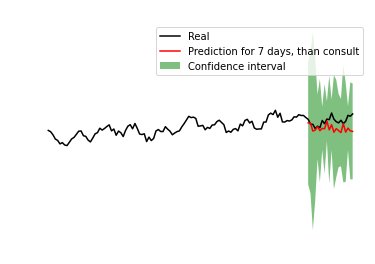

In [36]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

plt.title("IBM Stock prices", color="white")

plt.plot(df_pred.index,
         df_pred.consume,
         color='black',
         label="Real")

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, than consult".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.legend()